# Analyzing NYC High School Data

## Introduction

The ["SAT" (Scholastic Aptitude Test)](https://en.wikipedia.org/wiki/SAT) is an exam taken by U.S. high school students before they apply to college. When deciding who to admit, colleges take the test scores into account, so performing well on it is important. There are three sections on the test, each with 800 possible points. The combined score is out of 2,400 possible points. High schools are often ranked based on their average SAT scores. Additionally, the scores are considered a measure of the quality of a school district as a whole.

There is controversy around this test (and other standardized tests): are they unfair to certain groups?

In this study we will investigate correlations between SAT scores and demographics like race, gender, income, and more.

![Alt text](https://institute4learning.com/blog/wp-content/uploads/2013/02/testing.jpg)


## Data

We will make us of data that is published by the City of New York. This includes SAT scores, demographic information and other data that is useful for our study. Here are the links to all of the data sets we'll be using:

* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt):  attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a): The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j): Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8): Surveys of parents, teachers, and students at each school

## Contents

The remainder of the notebook contains the following sections:

* Data preparation and cleaning
* Overview of the data
* Data analysis and visualization
* SAT scores per boro and per district
* Conclusions

## Data preparation and cleaning

In this section, we will first read in all the data, and do necessary data cleaning. Since all datasets are interrelated, we will combine them into a single dataset, that we can next use to find correlations.

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Overview of the data

Before we continue with analysis and visualization, let's first take a look at the `combined` dataframe and the correlation table that we have created in the previous step.

In [10]:
#Check the size of our dataframe
print ('Nr of columns: ', combined.shape[1])
print ('Nr of rows: ', combined.shape[0])

Nr of columns:  160
Nr of rows:  363


By printing out the shapes above, we see that we have data for `363` schools and `161` attributes. Let's take a look at a sample.

In [11]:
# Show a sample of the data, for all columns in our dataframe
# For all floats, show two decimals
pd.options.display.float_format = '{:.2f}'.format
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.00,404.00,363.00,1122.00,0,129.03,197.04,...,Then to New York City residents,0,0,0.00,0.00,0.00,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.71,-73.99,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.00,423.00,366.00,1172.00,UNIVERSITY NEIGHBORHOOD H.S.,39.00,49.00,...,0,0,0,0.00,0.00,0.00,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.71,-73.98,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.00,402.00,370.00,1149.00,EAST SIDE COMMUNITY HS,19.00,21.00,...,0,0,0,0.00,0.00,0.00,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.73,-73.98,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.00,433.00,384.00,1207.00,0,129.03,197.04,...,0,0,0,0.00,0.00,0.00,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.72,-73.99,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.00,574.00,525.00,1621.00,"NEW EXPLORATIONS SCI,TECH,MATH",255.00,377.00,...,0,0,0,0.00,0.00,0.00,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.72,-73.98,01


In addition we have a table `correlations` that contains the correlations between the overall SAT score (`sat_score`) and all other columns. Let's print the table out.

In [12]:
# Sample correlations between SAT score and other attributes
pd.options.display.max_rows = 200
# Show 3 decimals
pd.options.display.float_format = '{:.3f}'.format
print (correlations)

SAT Critical Reading Avg. Score         0.987
SAT Math Avg. Score                     0.973
SAT Writing Avg. Score                  0.988
sat_score                               1.000
AP Test Takers                          0.523
Total Exams Taken                       0.514
Number of Exams with scores 3 4 or 5    0.463
Total Cohort                            0.325
CSD                                     0.043
NUMBER OF STUDENTS / SEATS FILLED       0.395
NUMBER OF SECTIONS                      0.363
AVERAGE CLASS SIZE                      0.381
SIZE OF SMALLEST CLASS                  0.250
SIZE OF LARGEST CLASS                   0.314
SCHOOLWIDE PUPIL-TEACHER RATIO            nan
schoolyear                                nan
fl_percent                                nan
frl_percent                            -0.722
total_enrollment                        0.368
ell_num                                -0.154
ell_percent                            -0.399
sped_num                          

## Data analysis and visualization

In this section, we will do analysis on the combined dataset and the correlations, mainly by visualization in a variety of charts. We will take a look at the correlation of SAT scores with:
* survey results
* safety
* racial factors
* gender
* AP scores

## Plotting survey correlations

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

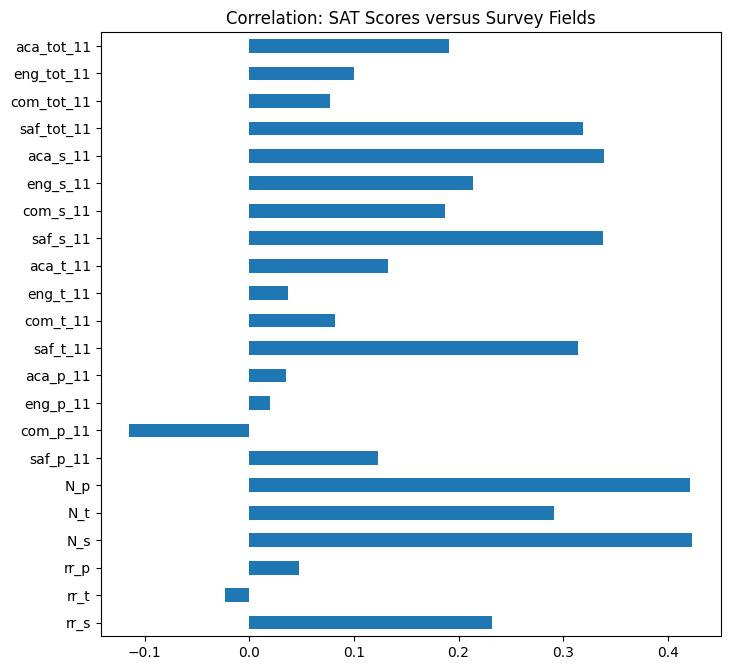

In [14]:
# Set up matplotlib in Jupyter notebook
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.barh \
   (title="Correlation: SAT Scores versus Survey Fields",figsize = (8,8))

There are high correlations between `N_s`, `N_t`, `N_p`, and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with `sat_score`. This make sense — it's difficult to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with `sat_score`, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

## Exploring Safety and SAT Scores

We just saw there is a positive correlation between (perceived) safety and respect and SAT scores. Let's explore this further.

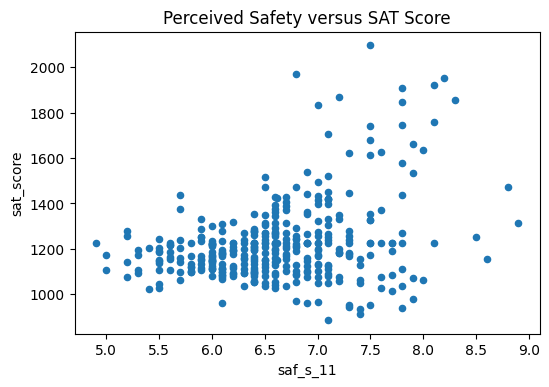

In [15]:
combined.plot.scatter('saf_s_11','sat_score', title="Perceived Safety versus SAT Score")

There appears to be a correlation between SAT scores and safety, although it isn't very strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than `6.5` has an average SAT score higher than `1600`.

## Borough Safety

We will now compute the average safety score for each borough and see if we can draw any conclusions.

In [16]:
boroughs = combined.groupby("boro").agg(np.mean)['saf_s_11']
print(boroughs)

boro
Bronx           6.607
Brooklyn        6.371
Manhattan       6.831
Queens          6.722
Staten Island   6.530
Name: saf_s_11, dtype: float64


For the five boroughs, `Manhattan` and `Queens` have high safety scores, whereas `Brooklyn` has low safety scores.

## Exploring Race and SAT Scores

Our dataset contains fields with the percentages of White, Black, Asian, and Hispanic students. Let's explore correlations between these and the SAT score.

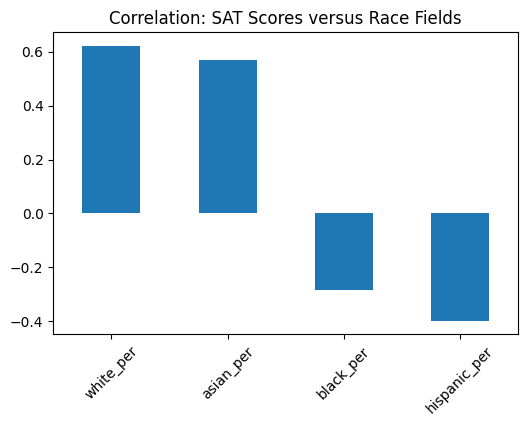

In [17]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_fields].plot.bar \
   (title="Correlation: SAT Scores versus Race Fields", rot=45)

It looks like a higher percentage of White or Asian students at a school correlates positively with SAT scores, whereas a higher percentage of Black or Hispanic students correlates negatively with SAT score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of Black or Hispanic students.

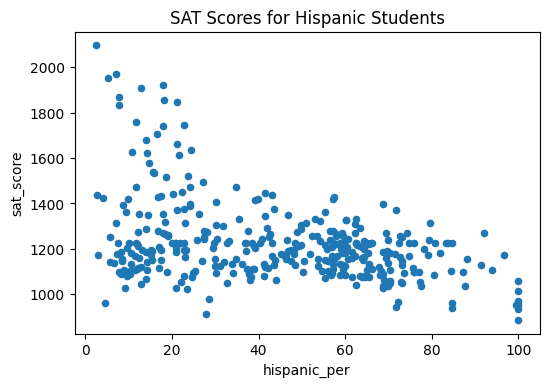

In [18]:
combined.plot.scatter("hispanic_per", "sat_score", 
                     title="SAT Scores for Hispanic Students")

This plot seems to confirm the strong correlation: schools with higher percentages of Hispanic students tend to score lower SAT scores. At the far end of the graph, we see several schools with a percentage of (close to) 100%. Let's explore those further.

In [19]:
# Schools with greater than 95% hispanic percentage
print(combined[combined['hispanic_per'] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above primarily serve recent immigrants to the U.S. These schools have many students who are learning English, which would explain the lower SAT scores.

In [20]:
# Schools with less than 10% hispanic percentage and SAT
# score greater than 1800
print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding and only admit students who pass an entrance exam. This doesn't explain the low `hispanic_per`, but it does explain why their students tend to do better on the SAT — they are students from all over New York City who did well on a standardized test.

## Exploring Gender and SAT Scores


Our dataset contains fields with the percentages of male and female students. Let's explore correlations between these and the SAT score.


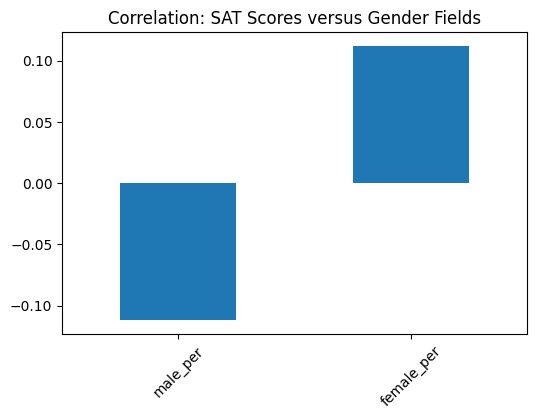

In [21]:
gender_fields = ["male_per", "female_per"]
combined.corr()['sat_score'][gender_fields].plot.bar \
   (title="Correlation: SAT Scores versus Gender Fields", rot=45)

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT scores, whereas a high percentage of males at a school negatively correlates with SAT scores. Neither correlation is extremely strong.

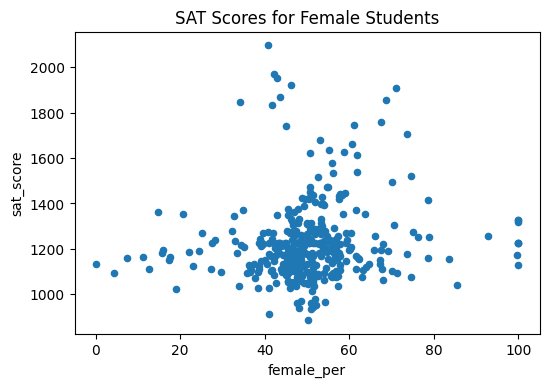

In [22]:
# Schools with female students
combined.plot.scatter("female_per", "sat_score", title="SAT Scores for Female Students")

Based on the scatter plot, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females (`60` to `80`) and high SAT scores.

In [23]:
# Schools with greater than 60% female students and an average SAT score greater than 1700.
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are highly selective liberal arts schools with high standards. As of 2022, Townsend Harris High School is ranked #1 in New York State and #19 nationally in 2022.

## Exploring AP Scores vs. SAT Scores

In the U.S., high school students take [Advanced Placement (AP) exams](https://en.wikipedia.org/wiki/Advanced_Placement_exams) to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

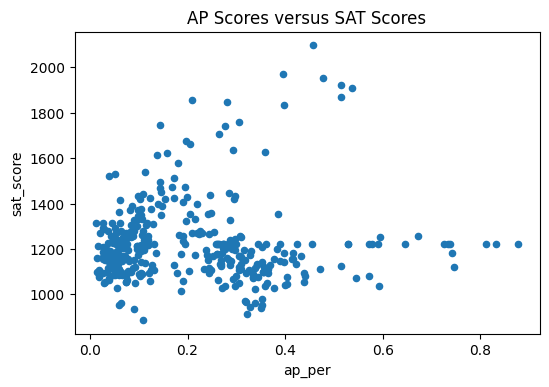

In [24]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] 

combined.plot.scatter("ap_per", "sat_score", title="AP Scores versus SAT Scores")

Unsurprisingly, there is a relationship between the percentage of students in a school who take the AP exam and their average SAT scores. However, the correlation is not very strong.

## SAT scores per borough and district

In our `combined` dataset, we have 363 schools. Each school belongs to a school district, and each school district is in one of the 5 boroughs that make up New York. In this section we are going to explore the extent that SAT scores vary over these boroughs, and also over the districts within these boroughs. 

## Prepare the data

Create aggregations, with average SAT scores at the borough level and at district level.

In [25]:
# Check the existing school districts
combined['school_dist'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32'],
      dtype=object)

So we have 5 boroughs which contains 32 districts and 363 schools.

In [26]:
# We now create a dataframe which only contains the columns that we need
combined.rename(columns = {'boro':'borough'}, inplace = True)
combined_less_columns = combined.loc[:,['borough','school_dist', 'sat_score', 'DBN']]

# Then, we create a dataframe that aggregates the data per borough and per district. Average the SAT score, and count the number of schools.
data_per_district_aggregated = combined_less_columns.groupby(['borough','school_dist'], as_index = False).agg({'sat_score': np.mean, 'DBN': 'count'})
data_per_district_aggregated.rename(columns = {'DBN': 'school_count'}, inplace = True)
data_per_district_aggregated

,borough,school_dist,sat_score,school_count
0,Bronx,07,1128.846,13
1,Bronx,08,1159.665,11
2,Bronx,09,1131.972,20
3,Bronx,10,1222.227,22
4,Bronx,11,1165.000,15
5,Bronx,12,1101.823,12
6,Brooklyn,13,1237.188,13
7,Brooklyn,14,1179.460,14
8,Brooklyn,15,1190.604,9
9,Brooklyn,16,1120.110,4


In [27]:
# Next, we further aggregate per borough. We also count the number of districts and the number of schools per borough.
data_per_borough_aggregated = data_per_district_aggregated.groupby('borough',as_index = False).agg({'sat_score': np.mean, 'school_dist': 'count', 'school_count': 'sum'})
data_per_borough_aggregated.rename(columns = {'school_dist': 'district_count'}, inplace = True)
data_per_borough_aggregated

,borough,sat_score,district_count,school_count
0,Bronx,1151.589,6,93
1,Brooklyn,1193.163,12,106
2,Manhattan,1269.572,6,90
3,Queens,1293.866,7,64
4,Staten Island,1382.500,1,10


The average SAT Score per borough isn't correct. This is, for every borough, the average is calculated through averaging the SAT score per district. As the districts don't contain the same number of schools, this calculation is incorrect. Let's calculate the correct value and replace. 

In [28]:
# Recalculate average SAT score per borough
sat_score_per_borough = combined_less_columns.groupby('borough',as_index = False).agg({'sat_score': np.mean})
sat_score_per_borough

,borough,sat_score
0,Bronx,1157.598
1,Brooklyn,1181.364
2,Manhattan,1278.331
3,Queens,1286.753
4,Staten Island,1382.500


In [29]:
data_per_borough_aggregated['sat_score'] = sat_score_per_borough['sat_score']
data_per_borough_aggregated


,borough,sat_score,district_count,school_count
0,Bronx,1157.598,6,93
1,Brooklyn,1181.364,12,106
2,Manhattan,1278.331,6,90
3,Queens,1286.753,7,64
4,Staten Island,1382.500,1,10


## Visualizing the data

We will now create bar charts with the average SAT score per borough and per district.

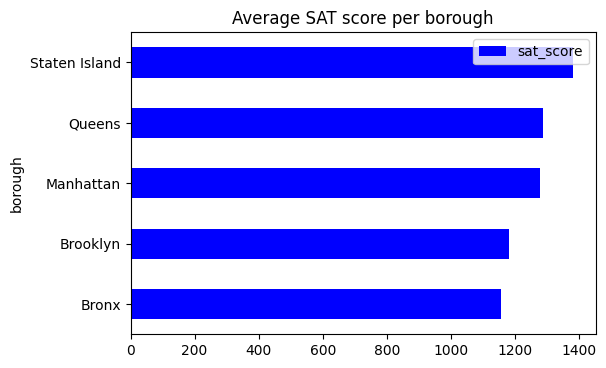

In [30]:
# Visualize the data for every borough
data_per_borough_aggregated[['borough', 'sat_score']].plot(kind = 'barh', x = 'borough', color = 'blue', title = 'Average SAT score per borough')

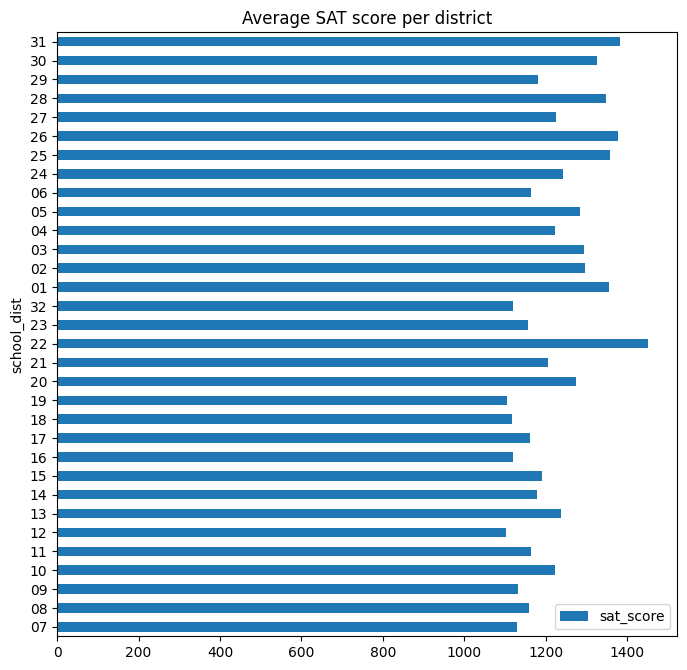

In [31]:
# Visualize the data for every school district
data_per_district_aggregated[['school_dist', 'sat_score']].plot(kind = 'barh', x = 'school_dist', figsize = (8,8), title = 'Average SAT score per district')

We can improve both these visualizations by adding colors and sorting the bar charts.

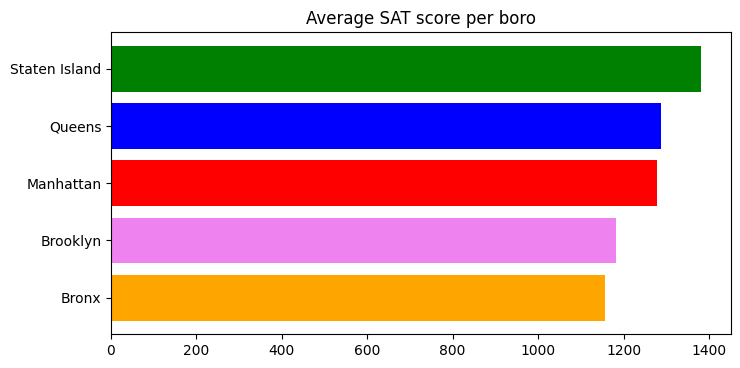

In [32]:
# Improved data visualization for every borough

# Give every borough a color.
color_dictionary = {'Bronx': 'orange', 'Staten Island': 'green', 'Manhattan': 'red', 'Queens': 'blue', 'Brooklyn': 'violet'}

# Define shorter names
dpb = data_per_borough_aggregated
dpd = data_per_district_aggregated

# Sort the dataframe so we can get a sorted bar chart
dpb.sort_values(by = 'sat_score', ascending = True, inplace = True)

# Create a function that returns the color of a borough
def getcolor(borough):
    return color_dictionary.get(borough)

# Create a list of colors to be used in the bar chart
dpbcolorlist = []

for an_entry in dpb['borough']:
    bcolor = getcolor(an_entry)
    dpbcolorlist.append(bcolor)

# Create a bar chart per borough (applying the colors)
fig, ax = plt.subplots(figsize = (8,4))
plt.barh (dpb['borough'], dpb['sat_score'], color = dpbcolorlist)
plt.title('Average SAT score per boro')
plt.show()

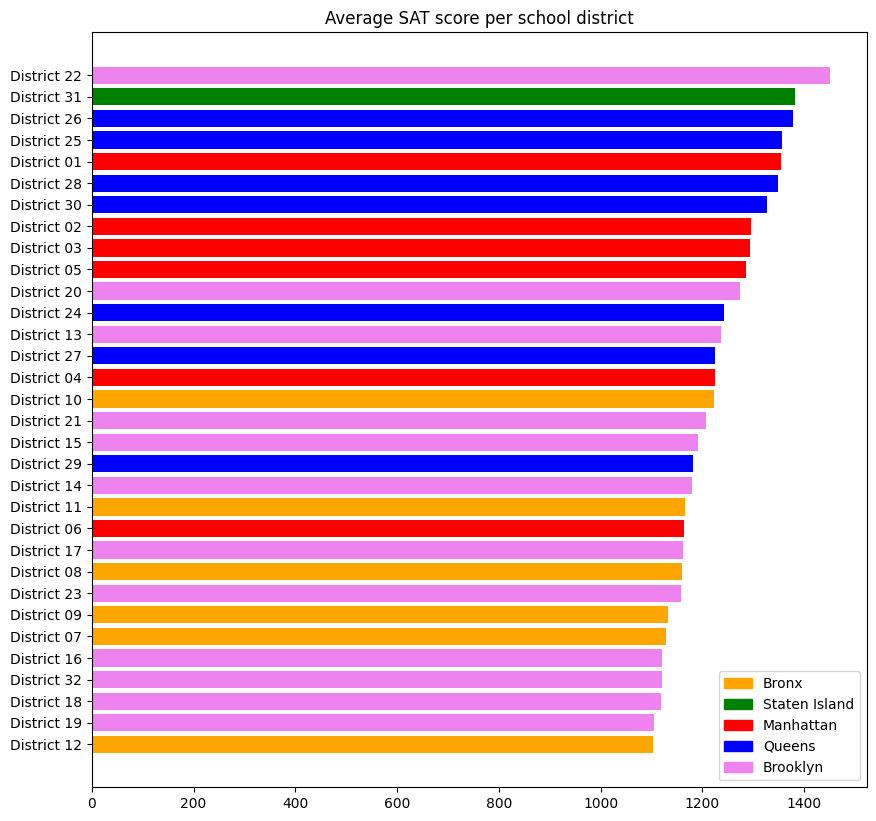

In [33]:
# Improved data visualization for every district

# Sort the dataframe so we can get a sorted bar chart
dpd.sort_values(by = 'sat_score', ascending = True, inplace = True)

# Create color list for the chart
dpdcolorlist= []

for an_entry in dpd['borough']:
    bcolor = getcolor(an_entry)
    dpdcolorlist.append(bcolor)

# Create legend for the chart
blabels = list(color_dictionary.keys())
bhandles = [plt.Rectangle((0,0),1,1, color=color_dictionary[label]) for label in blabels]

# Create a bar chart per district(applying the colors)
fig, ax = plt.subplots(figsize = (10,10))
plt.barh ('District '+ dpd['school_dist'], dpd['sat_score'], color = dpdcolorlist)
plt.title('Average SAT score per school district')
plt.legend(bhandles, blabels, loc = 4)
plt.show()

From this chart, is is clear that there is a significant difference in SAT scores accross different boroughs. In Queens, almost all districts are in the top half of the chart. However, for Bronx, almost all districts are at the bottom of the chart. Brooklyn contains the highest scoring district, but also many districts in the lower ranges of the chart.

## Conclusions

In this study we have combined (publicly available) data of NYC schools, and explored the correlation between SAT scores and multiple factors. We observed that:
* SAT scores tend to be higher at schools with a higher (perceived) safety 
* SAT scores tend to be higher at schools with high percentages of White and Asian students, and lower at schools with high percentages of Hispanic and Black students
* SAT scores tend to be higher at schools with above average percentages of female students

Also we saw that the average SAT scores differ significantly over the 5 boroughs of New York, and then within these boroughs there are still significant differences per school district.